In [29]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from optht import optht
import joblib
import imageio
from skimage import data
from skimage.color import rgb2gray
import matplotlib.image as mpimg
import math
import plotly.express as px  #visualisation
import plotly.graph_objects as go #visualisation

import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')
np.random.seed(42)
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [48]:
df= pd.read_csv(r'data\Wine_quality_clean.csv')

In [7]:
df

,type,fixed acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,density,volatile acidity,chlorides,sulphates,pH,alcohol,quality_label
0,white,7.0,0.36,20.7,45.0,170.0,1.00100,0.270,0.045,0.45,3.00,8.8,1
1,white,6.3,0.34,1.6,14.0,132.0,0.99400,0.300,0.049,0.49,3.30,9.5,1
2,white,8.1,0.40,6.9,30.0,97.0,0.99510,0.280,0.050,0.44,3.26,10.1,1
3,white,7.2,0.32,8.5,47.0,186.0,0.99560,0.230,0.058,0.40,3.19,9.9,1
4,white,7.2,0.32,8.5,47.0,186.0,0.99560,0.230,0.058,0.40,3.19,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,red,6.8,0.08,1.9,28.0,38.0,0.99651,0.620,0.068,0.82,3.42,9.5,1
6156,red,6.2,0.08,2.0,32.0,44.0,0.99490,0.600,0.090,0.58,3.45,10.5,0
6157,red,6.3,0.13,2.3,29.0,40.0,0.99574,0.510,0.076,0.75,3.42,11.0,1
6158,red,5.9,0.12,2.0,32.0,44.0,0.99547,0.645,0.075,0.71,3.57,10.2,0


In [8]:
df = pd.get_dummies(df, columns=['type'])

In [19]:
#X_final = df.drop(['quality_label'],axis=1)
#X_final = X_final.to_numpy()
#X_final

In [18]:
#y_final = df[['quality_label']].to_numpy()
#y_final = y_final.reshape(-1, 1)
#y_final

In [20]:
X_final = df.drop(['quality_label'],axis=1)
y_final = df[['quality_label']]

In [14]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=True) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [21]:
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X_final,y_final)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators = 850, max_depth = 34, min_samples_leaf = 1, min_samples_split = 3, 
max_features =3 , random_state=0)
clf.fit(X_train_scaled, y_train)
p=clf.predict(X_test_scaled)
print('Acurácia', accuracy_score(y_test,p))

C:\Users\DELL\AppData\Local\Temp\ipykernel_16560\3635386988.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_scaled, y_train)


Acurácia 0.8068181818181818


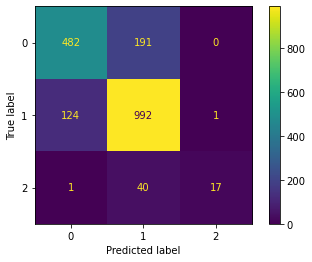

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,p)

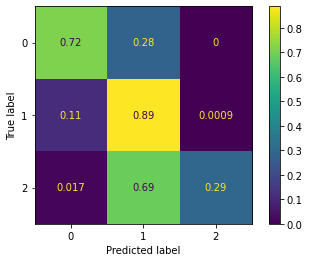

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test,p, normalize = 'true')

In [27]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestClassifier(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= accuracy_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-14 15:59:23,384] A new study created in memory with name: no-name-935be3f5-6214-4a34-8a3a-361e3636cf0c


In [43]:
#study.optimize(objective, n_trials=50,show_progress_bar=True)

#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [42]:
joblib.dump(study, "study_RandomForest.pkl")

['study_RandomForest.pkl']

In [38]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = GradientBoostingClassifier(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= accuracy_score(y_test,p)
    return score

    
study_gb = optuna.create_study(direction='maximize')

[I 2022-12-14 16:45:49,666] A new study created in memory with name: no-name-06d916ef-9aee-4b3d-83d8-5cd22f0c7b99


In [45]:
#study_gb.optimize(objective, n_trials=50,show_progress_bar=True)

#trial = study_gb.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [44]:
joblib.dump(study_gb, "study_GradientBoosting.pkl")

['study_GradientBoosting.pkl']

## Balancing the data

In [71]:
df2 = pd.read_csv(r'data\Wine_quality_clean.csv')
df_white = pd.read_csv(r'data\White_Wine_clean.csv')
df_red = pd.read_csv(r'data\Red_Wine_clean.csv')

In [73]:
df_white = df_white.drop(['type'],axis=1)

In [74]:
df_red = df_red.drop(['type'],axis=1)

<BarContainer object of 3 artists>

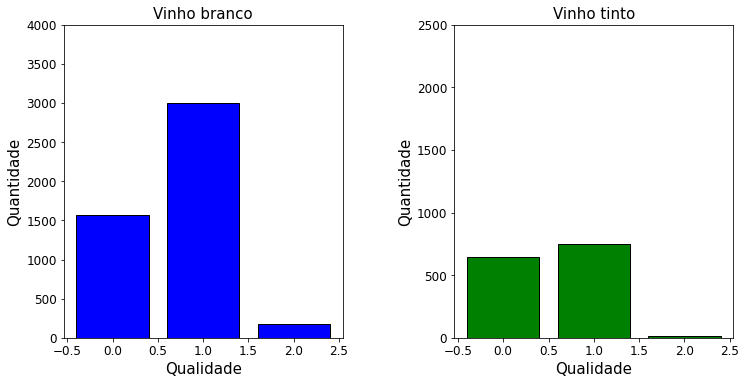

In [50]:
fig = plt.figure(figsize = (12, 6))
#title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.4)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Vinho branco",size=15)
ax1.set_xlabel("Qualidade",size=15)
ax1.set_ylabel("Quantidade",size=15) 
rw_q = df2.quality_label[df2.type == 'white'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 4000])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.bar(rw_q[0], rw_q[1], color='blue', edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Vinho tinto",size=15)
ax2.set_xlabel("Qualidade",size=15)
ax2.set_ylabel("Quantidade",size=15) 
ww_q = df2.quality_label[df2.type == 'red'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.bar(ww_q[0], ww_q[1], color='green', edgecolor='black', linewidth=1)

In [51]:
from imblearn.over_sampling import SMOTE

In [75]:
oversample = SMOTE()
X_final = df_red.drop(['quality_label'],axis=1)
y_final = df_red[['quality_label']]
X_red,y_red = oversample.fit_resample(X_final,y_final)

In [84]:
#before SMOTE
df_red[['quality_label']].value_counts()

quality_label
1                745
0                645
2                 16
dtype: int64

In [85]:
#after SMOTE
y_red.value_counts()

quality_label
0                745
1                745
2                745
dtype: int64

In [86]:
df_red_smote = pd.concat([X_red,y_red],axis=1)

In [88]:
df_red_smote['type'] = 'red'

In [89]:
X_final = df_white.drop(['quality_label'],axis=1)
y_final = df_white[['quality_label']]
X_white,y_white = oversample.fit_resample(X_final,y_final)

In [90]:
#before SMOTE
df_white[['quality_label']].value_counts()

quality_label
1                3004
0                1574
2                 176
dtype: int64

In [91]:
#after SMOTE
y_white.value_counts()

quality_label
0                3004
1                3004
2                3004
dtype: int64

In [92]:
df_white_smote = pd.concat([X_white,y_white],axis=1)
df_white_smote['type'] = 'white'

In [93]:
df_smote = pd.concat([df_red_smote,df_white_smote],axis=0)

In [94]:
df_smote

,fixed acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,density,volatile acidity,chlorides,sulphates,pH,alcohol,quality_label,type
0,7.400000,0.000000,1.900000,11.000000,34.000000,0.997800,0.700000,0.076000,0.560000,3.510000,9.400000,0,red
1,7.800000,0.000000,2.600000,25.000000,67.000000,0.996800,0.880000,0.098000,0.680000,3.200000,9.800000,0,red
2,7.800000,0.040000,2.300000,15.000000,54.000000,0.997000,0.760000,0.092000,0.650000,3.260000,9.800000,0,red
3,11.200000,0.560000,1.900000,17.000000,60.000000,0.998000,0.280000,0.075000,0.580000,3.160000,9.800000,1,red
4,7.400000,0.000000,1.900000,11.000000,34.000000,0.997800,0.700000,0.076000,0.560000,3.510000,9.400000,0,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,6.393215,0.311525,3.294901,36.305099,92.457649,0.990138,0.252373,0.032288,0.668816,3.221525,12.569490,2,white
9008,8.100000,0.440000,14.100000,43.000000,145.000000,1.000600,0.170000,0.053000,0.750000,3.280000,8.800000,2,white
9009,6.634617,0.297033,4.773086,29.148360,154.395625,0.991601,0.227033,0.063017,0.484560,3.227033,12.110984,2,white
9010,7.199394,0.352073,2.518910,34.000000,107.396367,0.990839,0.287927,0.044604,0.521952,3.313721,12.800000,2,white


In [96]:
df_smote.to_csv(r'data\BalancedData.csv', index=False)

<BarContainer object of 3 artists>

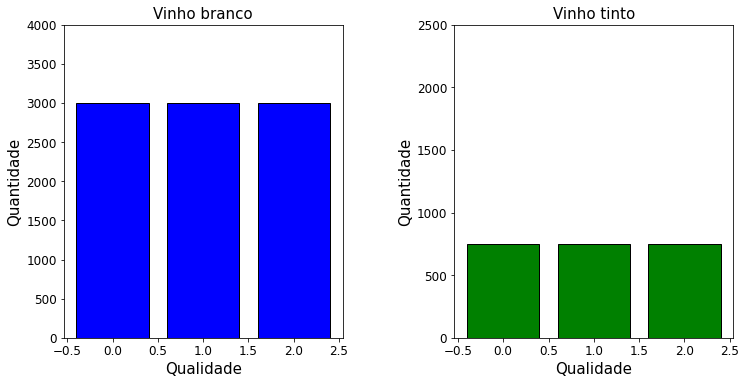

In [98]:
fig = plt.figure(figsize = (12, 6))
#title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.4)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Vinho branco",size=15)
ax1.set_xlabel("Qualidade",size=15)
ax1.set_ylabel("Quantidade",size=15) 
rw_q = df_smote.quality_label[df_smote.type == 'white'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 4000])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.bar(rw_q[0], rw_q[1], color='blue', edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Vinho tinto",size=15)
ax2.set_xlabel("Qualidade",size=15)
ax2.set_ylabel("Quantidade",size=15) 
ww_q = df_smote.quality_label[df_smote.type == 'red'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.bar(ww_q[0], ww_q[1], color='green', edgecolor='black', linewidth=1)

In [99]:
df_smote = pd.get_dummies(df_smote, columns=['type'])
X_smote_final = df_smote.drop(['quality_label'],axis=1)
y_smote_final = df_smote[['quality_label']]

In [100]:
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X_smote_final,y_smote_final)

In [101]:
clf = RandomForestClassifier(n_estimators = 850, max_depth = 34, min_samples_leaf = 1, min_samples_split = 3, 
max_features =3 , random_state=0)
clf.fit(X_train_scaled, y_train)
p=clf.predict(X_test_scaled)
print('Acurácia', accuracy_score(y_test,p))

C:\Users\DELL\AppData\Local\Temp\ipykernel_16560\3818236541.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_scaled, y_train)


Acurácia 0.8835555555555555


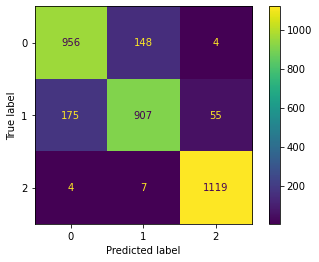

In [102]:
ConfusionMatrixDisplay.from_predictions(y_test,p)

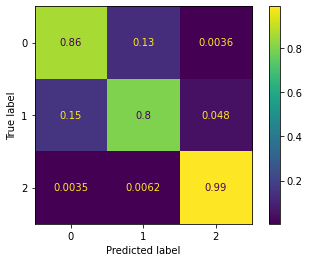

In [103]:
ConfusionMatrixDisplay.from_predictions(y_test,p, normalize = 'true')